### Libraries

In [1]:
from imblearn.over_sampling import SMOTE
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from numpy import ones
from numpy import zeros
from numpy.random import randint
from numpy.random import randn
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### SMOTE

In [2]:
# enter target commodity
commodity = 'Cr'
features_labels_file = f'./{commodity}/features_labels_{commodity}.csv'
features_labels = pd.read_csv(features_labels_file, index_col=False)
categorical_features_columns = []

for column in features_labels.columns:
    if features_labels[column].nunique() == 2:
        categorical_features_columns.append(column)

categorical_features_columns.remove('label')

features_list_label = features_labels.columns.tolist()
features_labels = features_labels.to_numpy()
features = features_labels[:, :-1]
labels = features_labels[:, -1]

# SMOTE
smote = SMOTE(random_state=1)
X_sm, y_sm = smote.fit_resample(features, labels)
smote_samples = np.concatenate((X_sm, y_sm.reshape(-1, 1)), axis=1)
# np.savetxt('SMOTE_Samples.csv', smote_samples, delimiter=',')
X_positive = smote_samples[np.where(smote_samples[:, -1]==1)]
X_positive = X_positive[:, 0:-1]

### GAN

In [3]:
# define the standalone discriminator model
def define_discriminator(n_inputs):
    model = Sequential()
    model.add(Dense(int(n_inputs*0.5), activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs):
    model = Sequential()
#     model.add(Dense(int(latent_dim*0.5), activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(int(n_outputs*0.5), activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# define the combined generator and discriminator model for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_samples = int(features.shape[0]-(2*labels.sum()))
# sample real data
def sample_real_data(n=n_samples):
    X_rand = X_positive[randint(X_positive.shape[0], size=n), :]
    y_rand = ones((n, 1))
    return X_rand, y_rand

# generate points in the latent space as input for the generator
def generate_latent_points(latent_dim, n=n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples with class labels
def generate_fake_samples(generator, latent_dim, n=n_samples):
    # generate points in the latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X_fake = generator.predict(x_input, verbose=0)
    # create class labels
    y_fake = zeros((n, 1))
    return X_fake, y_fake

n_epochs = 20000
smote_gan_file = f'./{commodity}/smote_gan_{commodity}.csv'
# evaluate the discriminator
def summarize_performance(epoch, generator, discriminator, latent_dim):
    # sample real data
    x_real, y_real = sample_real_data()
    # evaluate the discriminator on real examples
    _, acc_real = discriminator.evaluate(X_sm, y_sm, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim)
    # evaluate the discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    return x_real, x_fake, acc_real, acc_fake
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=n_epochs, n_batch=128, n_eval=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    acc_real_all = []
    acc_fake_all = []
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = sample_real_data(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in the latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            # summarize discriminator performance
            x_real, x_fake, acc_real, acc_fake = summarize_performance(i, g_model, d_model, latent_dim)
            print(i+1, acc_real, acc_fake)
            # scatter plot real and fake data points
            plt.scatter(x_real[:, 0], x_real[:, 14], color='red')
            plt.scatter(x_fake[:, 0], x_fake[:, 14], color='blue')
            plt.xlabel('Total Magnetic Intensity')
            plt.ylabel('Bouger Anomaly')
            plt.show()
        if i == n_epochs-1:
            x_fake_ones = ones((x_fake.shape[0], 1))
            x_fake = np.concatenate((x_fake, x_fake_ones), axis=1)
            smote_gan_samples = np.concatenate((features_labels, x_fake), axis=0)
            smote_gan_samples = pd.DataFrame(smote_gan_samples, columns=features_list_label)
            for column in categorical_features_columns:
                for row in range(smote_gan_samples.shape[0]):
                    if smote_gan_samples[column][row] > 0.5:
                        smote_gan_samples[column][row] = 1
                    else:
                        smote_gan_samples[column][row] = 0
            smote_gan_samples.to_csv(smote_gan_file, index=False)
    return smote_gan_samples

1000 0.9759522080421448 0.9854227304458618


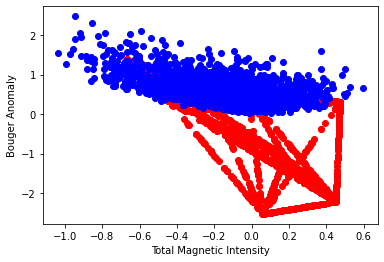

2000 0.9724015593528748 0.9980563521385193


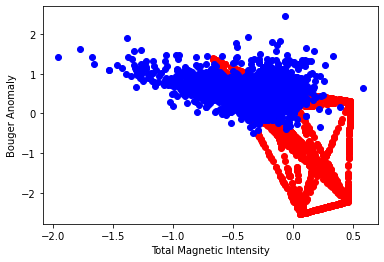

3000 0.977404773235321 0.997732400894165


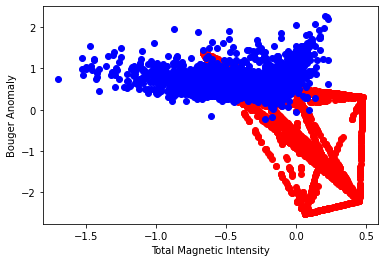

4000 0.9908004999160767 0.9906057715415955


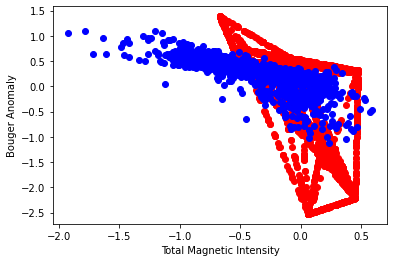

5000 0.99644935131073 0.9938451647758484


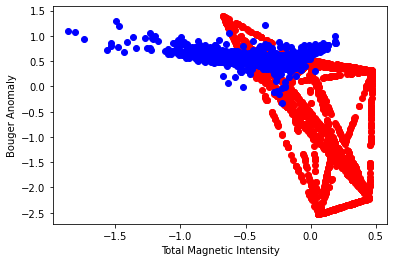

6000 0.9790187478065491 0.9919015169143677


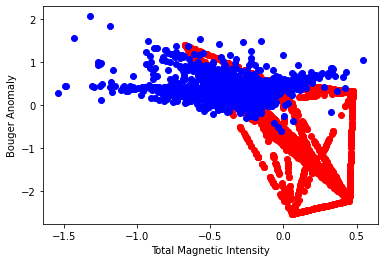

7000 0.9917688965797424 0.9987042546272278


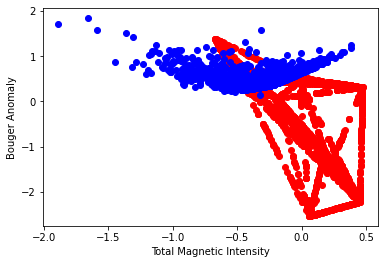

8000 0.9919303059577942 0.9860706329345703


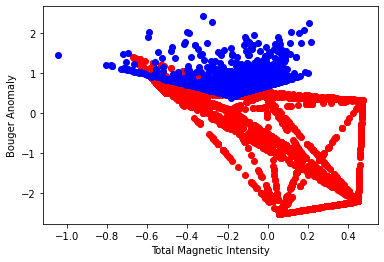

9000 0.9946739673614502 1.0


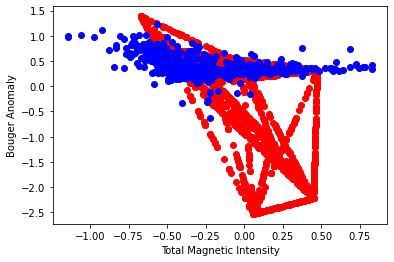

10000 0.9962879419326782 0.9828312397003174


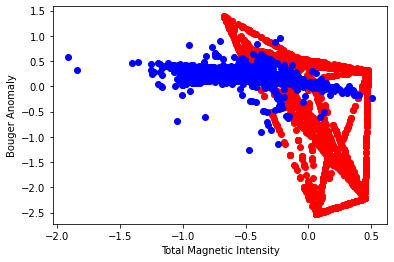

11000 0.9998385906219482 0.9987042546272278


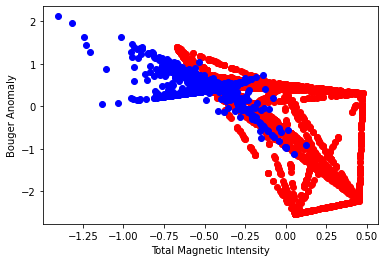

12000 0.9995158314704895 0.9928733110427856


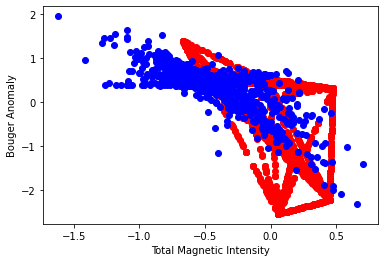

13000 0.9995158314704895 0.9996760487556458


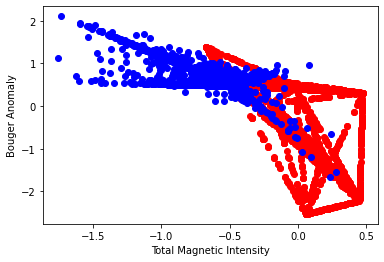

14000 0.9570690989494324 1.0


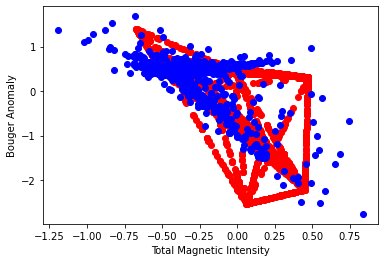

15000 0.9943512082099915 0.9786199927330017


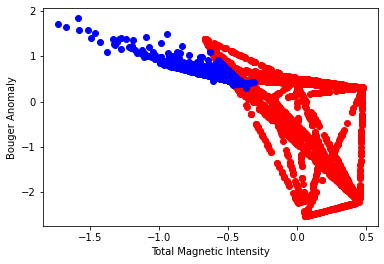

16000 0.9564235210418701 0.997732400894165


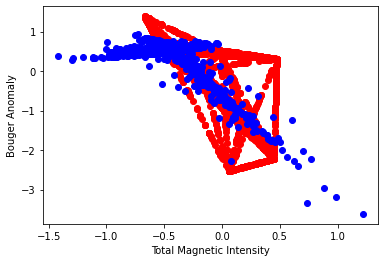

17000 0.975629448890686 0.9996760487556458


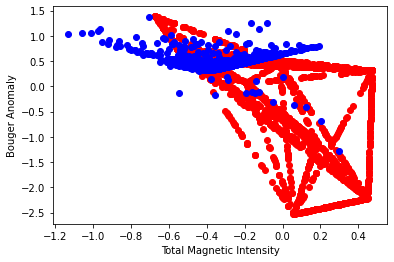

18000 0.9988702535629272 1.0


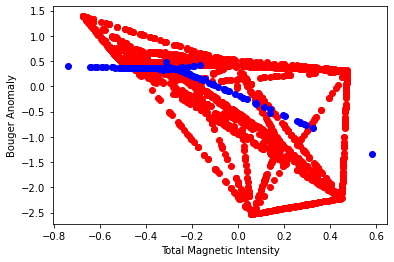

19000 0.9943512082099915 1.0


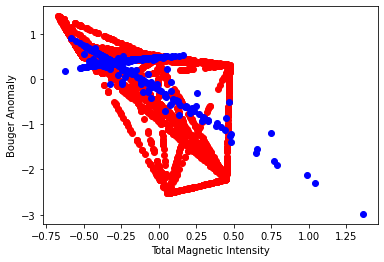

20000 0.9995158314704895 0.9974085092544556


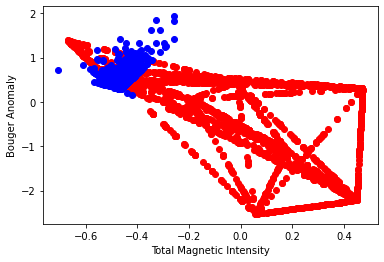

In [4]:
# size of the latent space
latent_dim = int(features.shape[1]*0.25)
# create the discriminator
discriminator = define_discriminator(features.shape[1])
# create the generator
generator = define_generator(latent_dim, features.shape[1])
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
smote_gan_samples = train(generator, discriminator, gan_model, latent_dim)

In [5]:
def interactive_hist(df, columns, colorby=None):
  """Plots interactive histograms of a dataframe. 
  Input:
    df: a pandas dataframe containing numerical columns
    columns: list of columns within dataframe
    colorby: column within dataframe to color data by
  Output:
    None
  Jack Maughan
  DATAROCK
  Date: 2/5/2022"""

  @interact(x=columns)
  def update(x):
      fig = px.histogram(df, x=x, nbins=100, color=colorby)
      fig.update_layout(xaxis = dict(title=x+' Values'), 
                      yaxis = dict(title='Counts'),
                      title = "Distribution Data - "+x, 
                      barmode='stack',    autosize=True,
                      width=800, height=600)
      fig.show('notebook')

def plot_3D_scatter(df, columns, colorby=None):
    """Plots interactive 3D scatter plots of dataframes. Number of dataframes
    in the list 'dfs' determines how many scatters are plotted (max. 6).
    Input:
    dfs: a list of pandas dataframes containing numerical columns
    columns: list of columns within dataframe
    subplot_titles: list of titles for each plot
    colorby: array/pd.Series to colorby (numerical)
    Output:
    None
    Jack Maughan
    DATAROCK
    Date: 2/5/2022"""
    
    df0 = df[df['color_label']==0]
    df1 = df[df['color_label']==1]
    df2 = df[df['color_label']==2]

    @interact(x=columns, y=columns, z=columns)
    def update(x, y, z):
        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=df0[columns][x], y=df0[columns][y], z=df0[columns][z], name ='Background', marker=dict(color = '#EF553B', size=6, line=dict(width=2, color='DarkSlateGrey')), mode='markers'))
        fig.add_trace(go.Scatter3d(x=df1[columns][x], y=df1[columns][y], z=df1[columns][z], name = 'GAN Deposits', marker=dict(color = '#00CC96', size=6, line=dict(width=2, color='DarkSlateGrey')), mode='markers'))
        fig.add_trace(go.Scatter3d(x=df2[columns][x], y=df2[columns][y], z=df2[columns][z], name = 'Actual Deposits', marker=dict(color = '#636EFA', size=6, line=dict(width=2, color='DarkSlateGrey')), mode='markers'))
        
        #Update layout to include axis titles
        fig.update_layout(height=1200, width=1200, showlegend=True, scene1 = dict(xaxis_title=x, yaxis_title=y, zaxis_title=z))
        fig.show('notebook')

smote_gan_samples['color_label'] = smote_gan_samples['label']
smote_gan_samples.loc[:7, 'color_label'] = 2
interactive_hist(smote_gan_samples, smote_gan_samples.columns, colorby='color_label')

C:\Users\efar0517\AppData\Local\Temp\ipykernel_13816\1454411501.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smote_gan_samples['color_label'] = smote_gan_samples['label']


interactive(children=(Dropdown(description='x', options=('SA_TMI_GDA94_mean', 'SA_TMI_GDA94_std', 'SA_TMI_GDA9…

In [6]:
plot_3D_scatter(smote_gan_samples, smote_gan_samples.columns, colorby=smote_gan_samples['color_label'])

interactive(children=(Dropdown(description='x', options=('SA_TMI_GDA94_mean', 'SA_TMI_GDA94_std', 'SA_TMI_GDA9…